# MLMR2018 materials data science challenge
### Hydrogen storage alloy performance modeling
Organized by Brian DeCost, Jason Hattrick-Simpers, and A. Gilad Kusne (NIST)

To exercise the concepts covered in the MLMR workshop, we will be reproducing and extending the modeling work in this paper:

Hattrick-Simpers, Jason R., Kamal Choudhary, and Claudio Corgnale. *A simple constrained machine learning model for predicting high-pressure-hydrogen-compressor materials.* Molecular Systems Design & Engineering (**2018**) https://dx.doi.org/10.1039/C8ME00005K

This study uses ~400 unique alloys from the [IEA/DOE/SANDIA Hydride Databases](http://hydrogenmaterialssearch.govtools.us/) (the hydrogen storage materials database (HSMD)) to build models for the ethalpy (and entropy) of hydrogenation of potential hydrogen storage alloys. In addition to these alloys, we have reserved an independent test set of 50 alloys. You have access to the compositions and structures of these alloys, but we are witholding the enthalpies of hydrogenation until the end of the materials data science challenge.

The baseline model from the paper is random forest regression using the [magpie feature set](https://dx.doi.org/10.1038/npjcompumats.2016.28), evaluated with 10-fold cross-validation on these ~400 HSMD entries.

After reproducing the results of the paper, we offer several suggestions on how to dig deeper to improve the performance of your model, or to try to gain some insight into your model. After selecting and tuning your favorite machine learning model from the workshop using the HSMD entries, you can submit your predictions to the MLMR team for [kaggle](https://kaggle.com)-style evaluation.

### Starter code

This notebook contains starter code to load the HSMD data, filter and clean the entries, construct magpie features using [matminer](https://github.com/hackingmaterials/matminer), and fit a linear model using scikit-learn.

In [1]:
# install pymatgen and matminer -- since they're not included in anaconda
import sys
# !{sys.executable} -m pip install pymatgen matminer
# Windows users: sorry! use conda
# conda install -c matsci pymatgen 
# conda install --yes -c conda-forge matminer

In [2]:
import re
import numpy as np
import pandas as pd
import pymatgen as mg

from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 14,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 0. Load the data!

In [3]:
# should not include the hold-out set... verify this.
df_full = pd.read_excel('data/Hydrogen Storage DataBase Full.xlsx')
df_full.head()

Material Class Composition Formula  Hydrogen Weight Percent  \
0            A2B         Mg2Ni1-yBey                      3.9   
1            A2B         Mg2Ni1-yCuy                      2.6   
2            A2B               Pr2Al                      1.4   
3            A2B         Th1.5Ce.5Al                      0.4   
4            A2B               Th2Al                      0.8   

  Heat of Formation (kJ/mol H2) Temperature (˚C)  \
0                       71 - 80              337   
1                       53 - 73              300   
2                           NaN              NaN   
3                           133              650   
4                           130              500   

  Pressure (Atmospheres Absolute)       Author Year  Reference Number  \
0             2017-03-05 00:00:00        Lupu, 1982               419   
1                         3.5 - 8  Darnaudery, 1983               417   
2                             NaN   Semenenko, 1985              1151   
3                          0.0003   Van Vucht, 1963               492   
4                           0.001   Van Vucht, 1963               492   

          Comment1 Comment2 Comment3  
0  (y = 0.15-0.25)      NaN      NaN  
1        (y = 0-1)      NaN      NaN  
2              NaN  (Amorp)      NaN  
3              NaN      NaN      NaN  
4              NaN      NaN      NaN

In [4]:
# load the test set... note the missing enthalpy values!
df_test = pd.read_excel('data/test_set_jhs.xlsx')
df_test.head()

comp  H2_wtpercent  Enthalpy  Temp_C   P_atm  \
0                 V0.85Ti0.1Fe0.05           1.5       NaN     100   53.14   
1  Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05           NaN       NaN     100   91.14   
2                          TiCr1.9           NaN       NaN      30   72.34   
3      (Ti0.97Zr0.03)1.1Cr1.6Mn0.4           NaN       NaN      99  527.90   
4              TiCr1.5Mn0.25Fe0.25           NaN       NaN      25   83.61   

  Phase  Entropy (J/molK)  
0   AB2               NaN  
1   AB2               NaN  
2   AB2               NaN  
3   AB2               NaN  
4   AB2               NaN

In [5]:
pd.Series(list(set(df_full['Composition Formula']).intersection(set(df_test['comp']))))

0     TiCrMn
1      CaNi5
2    TiMn1.5
dtype: object

It appears that only three compositions overlap between the full dataset and the holdouts

#### 1. Data cleaning: remove complex oxides, Mg, and references to Mm wt % and variable composition...
Data cleaning is one of the most important components of applying ML models to real-world data... We've done the task for you!

For this dataset, this amounts to writing regular expressions to filter out alloys with ill-defined compositions and calculating the mean value for entries reported as ranges.

This is more consistent and scalable than the manual filtering process used for the original paper, but frankly probably required more time....

![data cleaning](https://www.kdnuggets.com/images/cartoon-machine-learning-class.jpg)

In [6]:
# remove (M) from composition string...
pattern = re.compile(r'\s*\(M\)')
# e.g. pattern.sub('', 'LaCo4.95Mn.05 (M)')
remove_m = lambda x: pattern.sub('', x)

has_mg = lambda x: 'Mg' in x
variable_comp = lambda x: 'x' in x or '-' in x or '+' in x or ('y' in x and 'Dy' not in x)
has_mischmetal = lambda x: 'Mm' in x
has_mischmetal_pct = lambda x: 'wt.% Mm' in x or 'w/o Mm' in x or 'M?' in x
has_oxygen = lambda x: ('O' in x) and ('Os' not in x)

formula_has_R = lambda x: 'RNi' in x
formula_has_Lm = lambda x: 'Lm' in x

# match parentheses, with at least one comma
has_parens = lambda x: re.search(r'\((.*),+(.*)\)', x) is not None

# clean up composition string
df = df_full.copy()
new_comp = df['Composition Formula'].apply(remove_m)
df['Composition Formula'] = new_comp

# remove rows where material class is Complex or Mg
df = df[~df['Material Class'].isin(['Complex', 'Mg'])]
# df2 = df2[~df2['Composition Formula'].apply(has_mg)]

# throw out records with variable composition
df = df[~df['Composition Formula'].apply(variable_comp)]

# throw out records with references to mischmetal in wt. %
df = df[~df['Composition Formula'].apply(has_mischmetal_pct)]

# throw out records containing oxygen
df = df[~df['Composition Formula'].apply(has_oxygen)]

# throw out complex compounds (formula contains a comma-separated list...)
df = df[~df['Composition Formula'].apply(has_parens)]

# throw out records containing mischmetal...
df = df[~df['Composition Formula'].apply(has_mischmetal)]

# throw out records using R for mischmetal... specific to one author
df = df[~df['Composition Formula'].apply(formula_has_R)]

# throw out records using Lm for Lanthanum-rich mischmetal... 
df = df[~df['Composition Formula'].apply(formula_has_Lm)]

- There are a couple random datetime entries from https://doi.org/10.1016/S0925-8388(97)00592-6 and https://doi.org/10.1016/S0360-3199(00)00011-2, and appear to be Excel's fault in the original datasheet.
- Zr.2 Ho.8 CoFe should be '1 - 8' kJ/mol H2
- the other should be '-5 - -15' kJ/mol H2...

- the rest of the entries are just ranges that need to be averaged or something, or thrown out.

In [7]:
def average_range(x):
    """ find enthalpies reported as ranges and convert that entry to the average of the reported range """
    if type(x) is str and '-' in x:
        return np.mean(list(map(float, x.split(' - '))))
    else:
        return x
    
s = df['Heat of Formation (kJ/mol H2)'].apply(average_range)
df.loc[:,'Heat of Formation (kJ/mol H2)'] = s

In [8]:
def is_numeric(x):
    """ throw out any remaining datetime or string entries """
    try: 
        float(x); 
        return True; 
    except (TypeError, ValueError): 
        return False

df = df[df['Heat of Formation (kJ/mol H2)'].apply(is_numeric)]

### 2. normalize composition strings
Just use pymatgen's composition parser -- it seems to work out of the box.

In [9]:
# throw out any rows with no heat of formation...
df = df[~pd.isna(df['Heat of Formation (kJ/mol H2)'])]

c = []
for idx, row in df.iterrows():
    c.append(mg.Composition(row['Composition Formula']))
    
df['composition'] = pd.Series(c, index=df.index)
df.head()

Material Class Composition Formula  Hydrogen Weight Percent  \
3             A2B         Th1.5Ce.5Al                      0.4   
4             A2B               Th2Al                      0.8   
17            A2B               Ti2Cu                      2.2   
29            A2B               Ti2Pd                      1.4   
37            A2B               Zr2Cu                      1.3   

   Heat of Formation (kJ/mol H2) Temperature (˚C)  \
3                            133              650   
4                            130              500   
17                           130              500   
29                            90              NaN   
37                           144              600   

   Pressure (Atmospheres Absolute)      Author Year  Reference Number  \
3                           0.0003  Van Vucht, 1963               492   
4                            0.001  Van Vucht, 1963               492   
17                            0.12      Kadel, 1978               523   
29                             NaN      Kadel, 1978               523   
37                           0.003     Pebler, 1966                12   

   Comment1 Comment2 Comment3   composition  
3       NaN      NaN      NaN  (Th, Ce, Al)  
4       NaN      NaN      NaN      (Th, Al)  
17      NaN      NaN      NaN      (Ti, Cu)  
29      NaN      NaN      NaN      (Ti, Pd)  
37      NaN      NaN      NaN      (Zr, Cu)

In [10]:
# now get compositions for the test set...
c_test = []
for idx, row in df_test.iterrows():
    c_test.append(mg.Composition(row['comp']))
    
df_test['composition'] = pd.Series(c_test, index=df_test.index)
df_test.head()

comp  H2_wtpercent  Enthalpy  Temp_C   P_atm  \
0                 V0.85Ti0.1Fe0.05           1.5       NaN     100   53.14   
1  Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05           NaN       NaN     100   91.14   
2                          TiCr1.9           NaN       NaN      30   72.34   
3      (Ti0.97Zr0.03)1.1Cr1.6Mn0.4           NaN       NaN      99  527.90   
4              TiCr1.5Mn0.25Fe0.25           NaN       NaN      25   83.61   

  Phase  Entropy (J/molK)              composition  
0   AB2               NaN              (V, Ti, Fe)  
1   AB2               NaN  (Ti, Zr, Mn, Cr, V, Fe)  
2   AB2               NaN                 (Ti, Cr)  
3   AB2               NaN         (Ti, Zr, Cr, Mn)  
4   AB2               NaN         (Ti, Cr, Mn, Fe)

Look at the target distribution: (consider predicting the log of the enthalpy instead of the value, )

/anaconda/envs/pyTen/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


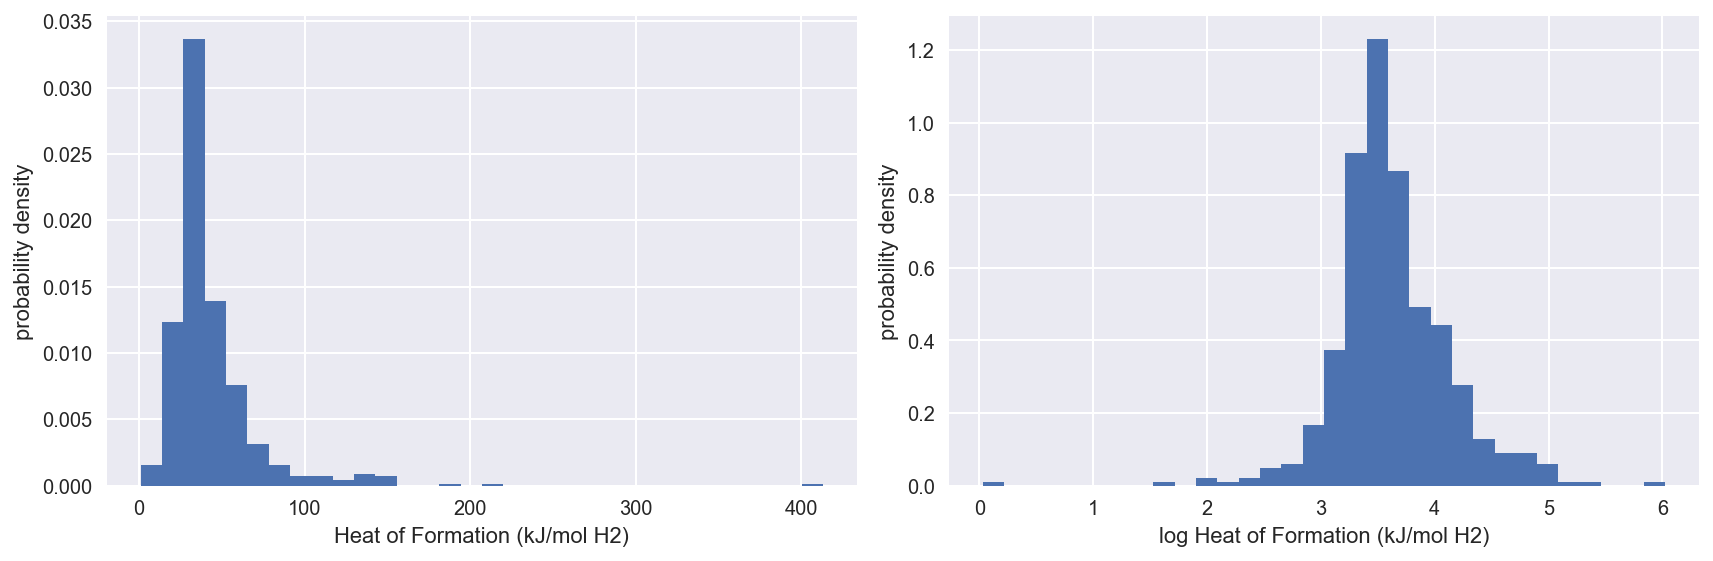

In [11]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.hist(df['Heat of Formation (kJ/mol H2)'].dropna().apply(float), bins=32, density=True);
ax1.set(xlabel='Heat of Formation (kJ/mol H2)', ylabel='probability density');

ax2.hist(np.log(df['Heat of Formation (kJ/mol H2)'].dropna().apply(float)), bins=32, density=True);
ax2.set(xlabel='log Heat of Formation (kJ/mol H2)', ylabel='probability density');

plt.tight_layout()

### 3. Finally, construct some (magpie) features and do some modeling

In [12]:
from matminer.featurizers import composition as composition_features

# use the standard magpie feature set...
# e.g. min, max, range, and mean for a collection of elemental properties (e.g. atomic number, covalent radius, space group number...)
f = composition_features.ElementProperty.from_preset('magpie')
X = f.featurize_dataframe(df, col_id='composition', inplace=False)
y = np.array(df['Heat of Formation (kJ/mol H2)'], dtype=float)

# matminer adds columns to the input dataframe... 
# so drop the original (metadata and target) columns from the new dataframe
n_metadata = len(df.keys())
X = X.iloc[:,n_metadata:]
X.head()

Widget Javascript not detected.  It may not be installed or enabled properly.


minimum Number  maximum Number  range Number  mean Number  avg_dev Number  \
3             13.0            90.0          77.0    59.000000       31.000000   
4             13.0            90.0          77.0    64.333333       34.222222   
17            22.0            29.0           7.0    24.333333        3.111111   
29            22.0            46.0          24.0    30.000000       10.666667   
37            29.0            40.0          11.0    36.333333        4.888889   

    mode Number  minimum MendeleevNumber  maximum MendeleevNumber  \
3          90.0                     15.0                     73.0   
4          90.0                     16.0                     73.0   
17         22.0                     43.0                     64.0   
29         22.0                     43.0                     62.0   
37         40.0                     44.0                     64.0   

    range MendeleevNumber  mean MendeleevNumber          ...            \
3                    58.0             34.833333          ...             
4                    57.0             35.000000          ...             
17                   21.0             50.000000          ...             
29                   19.0             49.333333          ...             
37                   20.0             50.666667          ...             

    range GSmagmom  mean GSmagmom  avg_dev GSmagmom  mode GSmagmom  \
3         0.000000       0.000000           0.00000       0.000000   
4         0.000000       0.000000           0.00000       0.000000   
17        0.000023       0.000015           0.00001       0.000023   
29        0.000023       0.000015           0.00001       0.000023   
37        0.000000       0.000000           0.00000       0.000000   

    minimum SpaceGroupNumber  maximum SpaceGroupNumber  \
3                      194.0                     225.0   
4                      225.0                     225.0   
17                     194.0                     225.0   
29                     194.0                     225.0   
37                     194.0                     225.0   

    range SpaceGroupNumber  mean SpaceGroupNumber  avg_dev SpaceGroupNumber  \
3                     31.0             219.833333                  8.611111   
4                      0.0             225.000000                  0.000000   
17                    31.0             204.333333                 13.777778   
29                    31.0             204.333333                 13.777778   
37                    31.0             204.333333                 13.777778   

    mode SpaceGroupNumber  
3                   225.0  
4                   225.0  
17                  194.0  
29                  194.0  
37                  194.0  

[5 rows x 132 columns]

In [13]:
print("Feature length: {}".format(X.columns.shape))

Feature length: (132,)


In [14]:
# compute magpie features for the test set...
Xt = f.featurize_dataframe(df_test, col_id='composition', inplace=False)
n_metadata = len(df_test.keys())
Xt = Xt.iloc[:,n_metadata:]
Xt.head()

Widget Javascript not detected.  It may not be installed or enabled properly.


minimum Number  maximum Number  range Number  mean Number  avg_dev Number  \
0            22.0            26.0           4.0    23.050000        0.295000   
1            22.0            40.0          18.0    24.366667        1.687778   
2            22.0            24.0           2.0    23.310345        0.903686   
3            22.0            40.0          18.0    23.610968        1.108969   
4            22.0            26.0           4.0    23.583333        1.055556   

   mode Number  minimum MendeleevNumber  maximum MendeleevNumber  \
0         23.0                     43.0                     55.0   
1         25.0                     43.0                     55.0   
2         24.0                     43.0                     49.0   
3         24.0                     43.0                     52.0   
4         24.0                     43.0                     55.0   

   range MendeleevNumber  mean MendeleevNumber          ...            \
0                   12.0             46.150000          ...             
1                   12.0             48.333333          ...             
2                    6.0             46.931034          ...             
3                    9.0             47.268710          ...             
4                   12.0             47.750000          ...             

   range GSmagmom  mean GSmagmom  avg_dev GSmagmom  mode GSmagmom  \
0        2.110663       0.105535          0.200513        0.00000   
1        2.110663       0.035329          0.069178        0.00031   
2        0.000023       0.000008          0.000010        0.00000   
3        0.000310       0.000048          0.000068        0.00000   
4        2.110663       0.175922          0.322457        0.00000   

   minimum SpaceGroupNumber  maximum SpaceGroupNumber  range SpaceGroupNumber  \
0                     194.0                     229.0                    35.0   
1                     194.0                     229.0                    35.0   
2                     194.0                     229.0                    35.0   
3                     194.0                     229.0                    35.0   
4                     194.0                     229.0                    35.0   

   mean SpaceGroupNumber  avg_dev SpaceGroupNumber  mode SpaceGroupNumber  
0             225.500000                  6.300000                  229.0  
1             211.733333                 11.822222                  217.0  
2             216.931034                 15.814507                  229.0  
3             215.032258                 14.926119                  229.0  
4             216.333333                 14.888889                  229.0  

[5 rows x 132 columns]

In [15]:
# naive train/val split, without consideration of duplicate compositions

y = np.array(df['Heat of Formation (kJ/mol H2)'], dtype=float)
std = preprocessing.StandardScaler()
std.fit(X)
Xs, Xts = std.transform(X), std.transform(Xt)
Xs = pd.DataFrame(data=Xs, index=X.index, columns=X.columns)

X_train, X_val, y_train, y_val = model_selection.train_test_split(Xs, y, test_size=0.2, random_state=42)

# standardize the input features for linear regression
# skip this for e.g. random forest...

print("Training Samples: {}".format(X_train.shape[0]))
print("Validation Samples: {}".format(X_val.shape[0]))

Training Samples: 433
Validation Samples: 109


/anaconda/envs/pyTen/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



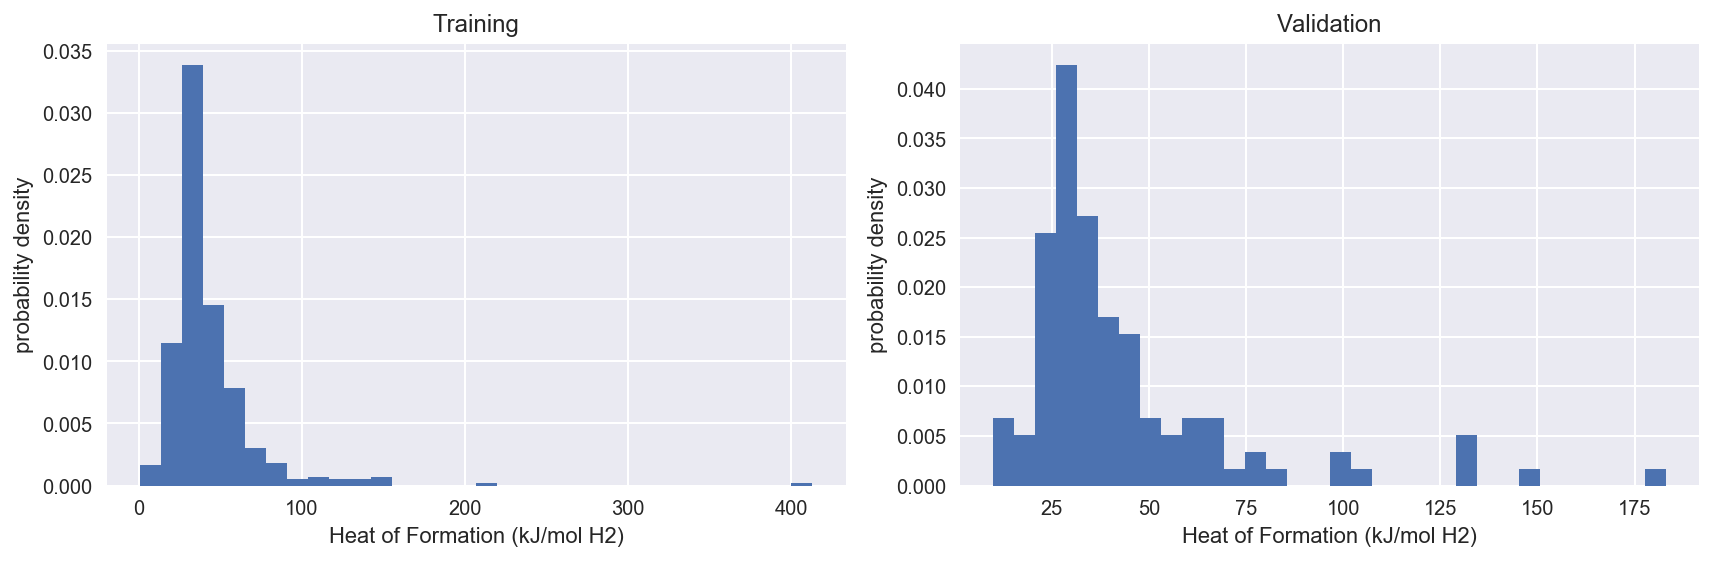

In [16]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.hist(y_train, bins=32, density=True);
ax1.set(xlabel='Heat of Formation (kJ/mol H2)', ylabel='probability density', title='Training');

ax2.hist(y_val, bins=32, density=True);
ax2.set(xlabel='Heat of Formation (kJ/mol H2)', ylabel='probability density', title='Validation');

plt.tight_layout()

Looks like we got a good split of the Hf values between training / validation.

/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



train: 7.669434479655696 kJ/mol
val: 19.919438210242458 kJ/mol


/anaconda/envs/pyTen/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



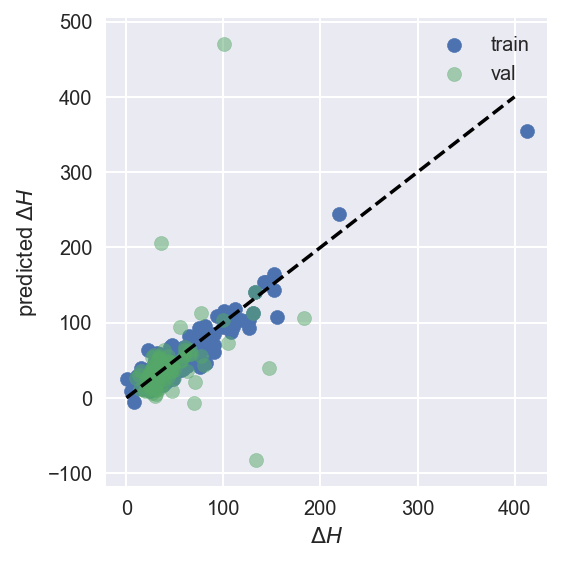

In [17]:
fig, ax = plt.subplots(figsize=(4,4))

model = linear_model.LinearRegression()

model.fit(X_train, y_train)
ax.scatter(y_train, model.predict(X_train), label='train')
ax.scatter(y_val, model.predict(X_val), label='val', alpha=0.5)
ax.plot((0,400), (0,400), linestyle='--', color='k')

ax.set(xlabel=r'$\Delta H$', ylabel = r'predicted $\Delta H$');
ax.legend()

print('train:', metrics.mean_absolute_error(y_train, model.predict(X_train)), 'kJ/mol')
print('val:', metrics.mean_absolute_error(y_val, model.predict(X_val)), 'kJ/mol')

In [18]:
# print out (and save) test set predictions
pred_test = model.predict(Xts)

with open('hydride_test_set_predictions.txt', 'w') as textfile:
    for idx, row in df_test.iterrows():
        print('{}, {}'.format(row.comp, pred_test[idx]))
        print('{}, {}'.format(row.comp, pred_test[idx]), file=textfile)

V0.85Ti0.1Fe0.05, 39.28061347222337
Ti0.9Zr0.1Mn1.4Cr0.35V0.2Fe0.05, 34.08432440972337
TiCr1.9, 17.721531440973372
(Ti0.97Zr0.03)1.1Cr1.6Mn0.4, 33.28744940972337
TiCr1.5Mn0.25Fe0.25, 35.77817206597337
TiCr1.5Mn0.2Fe0.3, 34.51791815972337
TiCrMn, 9.675633003473372
(Ti0.8Zr0.2)1.1CrMn, 8.490086128473372
TiFe, 37.72983222222337
TiMn1.5, 34.73569159722337
TiCr1.75Al0.05, 37.87338690972337
TiCr1.7Al0.2, 32.16293769097337
TiCr1.6Mn0.2, 30.635105659723372
TiCr0.95Mn0.95, 24.864597847223372
TiCr1.75Ni0.1, 25.861668159723372
TiCr1.7Ni0.3, 25.637547065973372
TiCr1.9Mo0.01, 40.04379706597337
Ti1.1CrMn, 26.572117378473372
(Ti0.85Zr0.15)1.1CrMn, 7.696629097223372
(Ti0.85Zr0.15)1.1Cr0.95Mo0.05Mn, 36.38119940972337
(Ti0.85Zr0.15)1.1Cr0.9Mo0.1Mn, 35.68539862847337
(Ti0.85Zr0.15)1.1Cr0.85Mo0.15Mn, 35.18735175347337
(Ti0.85Zr0.15)1.1Cr0.98W0.02Mn, 24.349461128473372
(Ti0.85Zr0.15)1.1Cr0.95W0.05Mn, 24.637058784723372
(Ti0.85Zr0.15)1.1Cr0.9W0.1Mn, 25.040867378473372
TiCr1.6Mn0.2Fe0.2, 35.17026190972337
Ti

## That's all for this notebook - save the training/test sets and load them up in the next notebook

In [38]:
with pd.HDFStore('data/data.h5') as h5f:
    h5f.put('df_full', df)
    h5f.put('df_test', df_test)
    h5f.put('X', X)
    h5f.put('X_test', Xt)

/anaconda/envs/pyTen/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['Material Class', 'Composition Formula', 'Heat of Formation (kJ/mol H2)', 'Temperature (˚C)', 'Pressure (Atmospheres Absolute)', 'Author Year', 'Comment1', 'Comment2', 'Comment3', 'composition']]


/anaconda/envs/pyTen/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['comp', 'Phase', 'composition']]




### 4. Baseline challenge

Random forest regression using magpie features. (**Don't apply standardization** -- this typically isn't necessary for tree-based models).

#### reproduce Jae's results with 10-fold randomized CV (on the training set)
- compare your 10-fold cross-validation performance with the paper
- save your predictions on the independent test set -- we'll evaluate them at the end of the challenge!
- can you do a feature importance analysis? What's features are important for these hydride materials?
- justify/interpret the model performance

In [199]:
# Random forest modeling and evaluation here...
from sklearn import ensemble

# try to match Weka defaults...
model = ensemble.RandomForestRegressor(n_estimators=100, max_features='log2')
cv_pred = model_selection.cross_val_predict(model, X, y, cv=10, verbose=True)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished


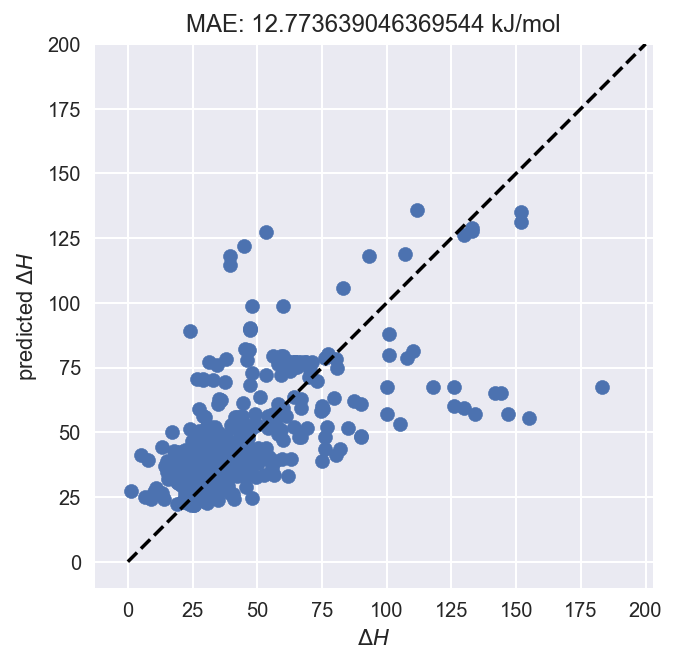

In [220]:
def parity_plot(y_true, y_pred, newfig=True, figsize=(5,5), lim=450):
    if newfig:
        plt.figure(figsize=figsize,
                   tight_layout=False)
        
    plt.scatter(y_true, y_pred)
    plt.plot((0,lim), (0,lim), linestyle='--', color='k')
    plt.xlim([-10,lim]); plt.ylim([-10,lim])
    plt.gca().set_aspect('equal','datalim')

    plt.xlabel(r'$\Delta H$')
    plt.ylabel(r'predicted $\Delta H$')
    plt.title('MAE: {} kJ/mol'.format(metrics.mean_absolute_error(y_true, y_pred)))

parity_plot(y, cv_pred, lim=200)

## Define a generic model fitting and evaluation function

In [218]:
# Generic Model Evaluation Function...

from scipy import stats
from sklearn import ensemble

def eval_model(estimator, X, y, hypes=None, n_splits=5, print_name=False):
    
    if print_name:
        print(estimator)
    
    cv = model_selection.KFold(n_splits=n_splits, shuffle=True)

    score = pd.DataFrame(columns=pd.MultiIndex.from_product([['train', 'val'], ['mae', 'pearson', 'spearman']]))
    
    for idx, (train, val) in enumerate(cv.split(X)):
        
        model_i = estimator() # Would eventually like to be able to pass hyperparameters here
        model_i.fit(X.iloc[train], y[train])

        # MAE
        score.loc[idx, ('train','mae')] = metrics.mean_absolute_error(y[train], model_i.predict(X.iloc[train]))
        score.loc[idx, ('val','mae')] = metrics.mean_absolute_error(y[val], model_i.predict(X.iloc[val]))

        # pearson -- print just the coefficient; throw away the p-value
        score.loc[idx, ('train','pearson')] = stats.pearsonr(y[train], model_i.predict(X.iloc[train]))[0]
        score.loc[idx, ('val','pearson')] = stats.pearsonr(y[val], model_i.predict(X.iloc[val]))[0]

        # spearman -- print just the coefficient; throw away the p-value
        score.loc[idx, ('train','spearman')] = stats.spearmanr(y[train], model_i.predict(X.iloc[train]))[0]
        score.loc[idx, ('val','spearman')] = stats.spearmanr(y[val], model_i.predict(X.iloc[val]))[0]
        
    model_i.fit(X, y)
    
    return score, model_i

## Let's fit every regression model sklearn has to offer.

Fit with scaled features "Xs"

In [186]:
lin_mods = pd.Series([s for s in vars(linear_model)['__all__'] if 'Classifier' not in s])
lin_mods

0                    ARDRegression
1                    BayesianRidge
2                       ElasticNet
3                     ElasticNetCV
4                            Hinge
5                            Huber
6                   HuberRegressor
7                             Lars
8                           LarsCV
9                            Lasso
10                         LassoCV
11                       LassoLars
12                     LassoLarsCV
13                     LassoLarsIC
14                LinearRegression
15                             Log
16              LogisticRegression
17            LogisticRegressionCV
18                   ModifiedHuber
19             MultiTaskElasticNet
20           MultiTaskElasticNetCV
21                  MultiTaskLasso
22                MultiTaskLassoCV
23       OrthogonalMatchingPursuit
24     OrthogonalMatchingPursuitCV
25      PassiveAggressiveRegressor
26                      Perceptron
27                 RandomizedLasso
28    RandomizedLogi

In [187]:
mod_idx = [0,1,3,6,10,30]
df_mods = pd.DataFrame()
df_mods['name'] = lin_mods.loc[mod_idx].copy()
df_mods.reset_index(inplace=True, drop=True)
df_mods

name
0     ARDRegression
1     BayesianRidge
2      ElasticNetCV
3    HuberRegressor
4           LassoCV
5  LinearRegression
6           RidgeCV

In [188]:
df_mods[['scores','estimator']] = df_mods.apply(lambda row: eval_model(getattr(linear_model, row['name']), Xs, y, print_name=True),
                                                axis=1,
                                                result_type='expand')

<class 'sklearn.linear_model.bayes.ARDRegression'>
<class 'sklearn.linear_model.bayes.BayesianRidge'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>


/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fittin

<class 'sklearn.linear_model.huber.HuberRegressor'>


/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



<class 'sklearn.linear_model.coordinate_descent.LassoCV'>


/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda/envs/pyten/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fittin

<class 'sklearn.linear_model.base.LinearRegression'>
<class 'sklearn.linear_model.ridge.RidgeCV'>


In [193]:
df_mods[['mae','mae_std']] = df_mods.apply(lambda row: row['scores'][('val','mae')].agg(['mean','std']),
                                           axis=1, result_type='expand')
df_mods

name                                             scores  \
0   ARDRegression       train                          val       ...   
1   BayesianRidge       train                          val       ...   
2    ElasticNetCV       train                          val       ...   
3  HuberRegressor       train                          val       ...   
4         LassoCV       train                          val       ...   
6         RidgeCV       train                          val       ...   

                                           estimator        mae   mae_std  
0  ARDRegression(alpha_1=1e-06, alpha_2=1e-06, co...  13.323501  2.254121  
1  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, co...  12.870445  2.417181  
2  ElasticNetCV(alphas=None, copy_X=True, cv=None...  11.907544  1.447504  
3  HuberRegressor(alpha=0.0001, epsilon=1.35, fit...  11.353750  1.441366  
4  LassoCV(alphas=None, copy_X=True, cv=None, eps...  12.338249  1.272009  
6  RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_...  12.073940  2.097877

Text(0,0.5,'Mean Absolute Error (5-fold CV)')

/anaconda/envs/pyten/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



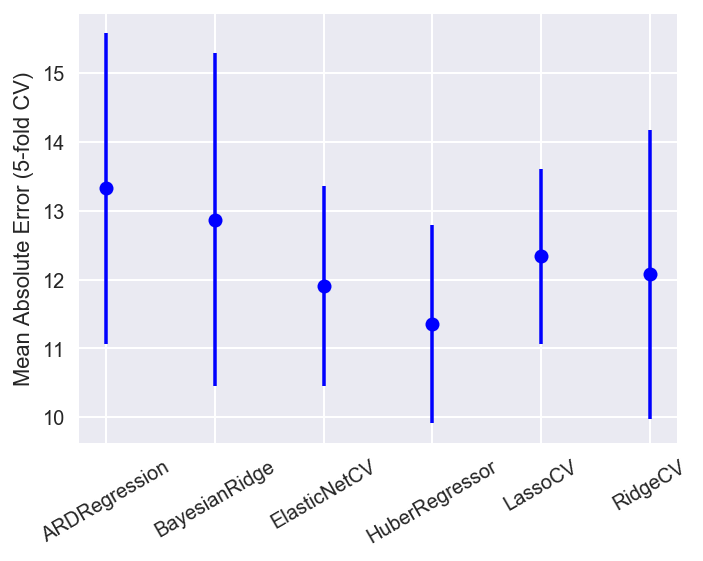

In [209]:
plt.figure(figsize=(5,4))
plt.errorbar('name','mae',yerr='mae_std', fmt='bo', data=df_mods)
plt.xticks(rotation=30)
plt.ylabel('Mean Absolute Error (5-fold CV)')

Well, those are all pretty much the same.

## Try same procedure on some ensemble models
Remember to fit with un-scaled features "X"

In [175]:
ens = pd.Series([s for s in vars(ensemble)['__all__'] if 'Classifier' not in s])
ens

0                  BaseEnsemble
1         RandomForestRegressor
2          RandomTreesEmbedding
3           ExtraTreesRegressor
4              BaggingRegressor
5               IsolationForest
6     GradientBoostingRegressor
7             AdaBoostRegressor
8                       bagging
9                        forest
10            gradient_boosting
11           partial_dependence
12              weight_boosting
dtype: object

In [177]:
df_ens = pd.DataFrame()
df_ens['name'] = ens.loc[[1,4,6,7]]
df_ens

name
1      RandomForestRegressor
4           BaggingRegressor
6  GradientBoostingRegressor
7          AdaBoostRegressor

In [178]:
df_ens[['scores','estimator']] = df_ens.apply(lambda row: eval_model(getattr(ensemble, row['name']), X, y, print_name=True),
                                              axis=1,
                                              result_type='expand')

<class 'sklearn.ensemble.forest.RandomForestRegressor'>
<class 'sklearn.ensemble.bagging.BaggingRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>


In [179]:
df_ens[['mae','mae_std']] = df_ens.apply(lambda row: row['scores'][('val','mae')].agg(['mean','std']),
                                           axis=1, result_type='expand')
df_ens

name  \
1      RandomForestRegressor   
4           BaggingRegressor   
6  GradientBoostingRegressor   
7          AdaBoostRegressor   

                                              scores  \
1       train                          val       ...   
4       train                          val       ...   
6       train                          val       ...   
7       train                          val       ...   

                                           estimator        mae   mae_std  
1  (DecisionTreeRegressor(criterion='mse', max_de...   9.201692  2.299237  
4  (DecisionTreeRegressor(criterion='mse', max_de...   9.079608  2.667802  
6  ([DecisionTreeRegressor(criterion='friedman_ms...   8.669693  1.415678  
7  (DecisionTreeRegressor(criterion='mse', max_de...  11.684118  2.315965

Text(0,0.5,'Mean Absolute Error (5-fold CV)')

/anaconda/envs/pyten/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



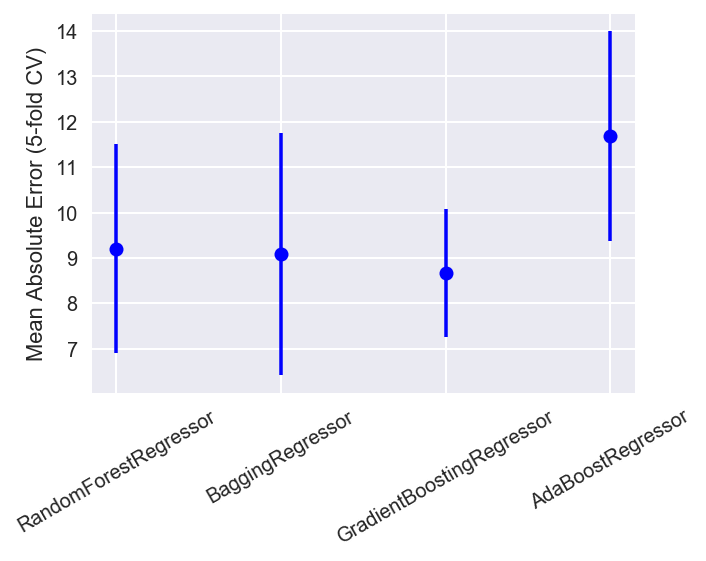

In [210]:
plt.figure(figsize=(5,4))
plt.errorbar('name','mae',yerr='mae_std', fmt='bo', data=df_ens)
plt.xticks(rotation=30)
plt.ylabel('Mean Absolute Error (5-fold CV)')

Ok, so what's up with our RandomForest now? Why is it suddenly way better?

In [228]:
df_ens.loc[6,'estimator']

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

NameError: name 'parity_plot' is not defined

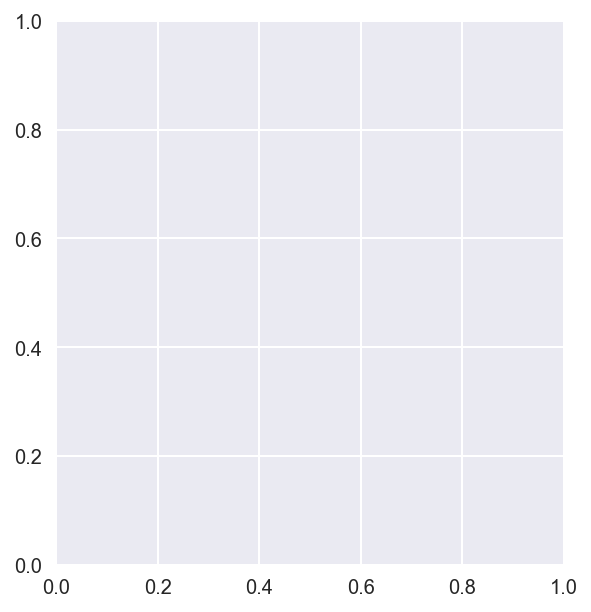

In [39]:
plt.figure(figsize=(10,5), tight_layout=False)
plt.subplot(1,2,1)
parity_plot(y_train, df_ens.loc[6,'estimator'].fit(X_train,y_train).predict(X_train), newfig=False)
plt.subplot(1,2,2)
parity_plot(y_val, df_ens.loc[6,'estimator'].fit(X_train,y_train).predict(X_val), newfig=False)

In [231]:
df_ens.loc[6,'estimator'].score(X_val,y_val)

0.5746255902583373

## Let's try a Grid Search on the hyperparameters of Gradient Boosting

In [270]:
from sklearn.model_selection import GridSearchCV
estimator = df_ens.loc[6,'estimator']
estimator.loss = 'lad'

parameters = {'max_depth': [2, 3, 4],
              'learning_rate': [0.08, 0.1, 0.12],
              'n_estimators': [80, 100, 120],
              'subsample': [0.9, 0.95, 1],
             }
reg = GridSearchCV(estimator, parameters, cv=4)
reg.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'learning_rate': [0.08, 0.1, 0.12], 'n_estimators': [80, 100, 120], 'subsample': [0.9, 0.95, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [271]:
df_res = pd.DataFrame(reg.cv_results_)
df_res.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
48       0.309611      0.011302         0.000582        0.000052   
15       0.237211      0.005716         0.000508        0.000029   
37       0.158901      0.002591         0.000424        0.000041   
70       0.252930      0.010843         0.000542        0.000032   
73       0.250175      0.007429         0.000529        0.000076   
78       0.371323      0.023766         0.000603        0.000029   
64       0.171530      0.008817         0.000472        0.000034   
43       0.233357      0.001115         0.000466        0.000010   
14       0.184698      0.009436         0.000431        0.000013   
22       0.286300      0.008403         0.000556        0.000028   
41       0.186223      0.005830         0.000448        0.000030   
11       0.159353      0.006290         0.000491        0.000036   
33       0.152330      0.005579         0.000395        0.000017   
17       0.218909      0.004420         0.000473        0.000025   
13       0.203868      0.007850         0.000486        0.000034   
51       0.375651      0.006204         0.000616        0.000051   
3        0.150373      0.009752         0.000523        0.000071   
23       0.263843      0.011283         0.000528        0.000028   
18       0.236680      0.005293         0.000470        0.000016   
40       0.199494      0.009543         0.000458        0.000011   
69       0.253886      0.003844         0.000711        0.000353   
46       0.225321      0.004807         0.000470        0.000037   
68       0.206149      0.011090         0.000493        0.000018   
21       0.285325      0.013709         0.000510        0.000012   
79       0.366867      0.026623         0.000596        0.000054   
50       0.287404      0.026663         0.000537        0.000033   
12       0.199579      0.006502         0.000476        0.000059   
49       0.321652      0.002688         0.000576        0.000034   
10       0.159735      0.003894         0.000427        0.000021   
71       0.243958      0.011307         0.000539        0.000019   
..            ...           ...              ...             ...   
6        0.152806      0.004787         0.000447        0.000045   
20       0.216278      0.013179         0.000450        0.000031   
58       0.143666      0.006647         0.000497        0.000069   
4        0.148667      0.004155         0.000500        0.000086   
16       0.231098      0.005344         0.000469        0.000021   
26       0.309992      0.008802         0.000544        0.000014   
54       0.120658      0.003534         0.000468        0.000026   
0        0.116749      0.011022         0.000403        0.000029   
59       0.134750      0.010380         0.000528        0.000138   
66       0.209684      0.007863         0.000544        0.000038   
42       0.234336      0.001181         0.000477        0.000025   
52       0.325298      0.011855         0.000552        0.000024   
34       0.147773      0.004776         0.000381        0.000021   
24       0.332052      0.005347         0.000542        0.000021   
45       0.223083      0.005321         0.000477        0.000054   
2        0.106840      0.007253         0.000422        0.000036   
77       0.284280      0.011243         0.000526        0.000035   
8        0.145479      0.003934         0.000432        0.000014   
56       0.109206      0.002974         0.000473        0.000030   
62       0.157359      0.006970         0.000468        0.000032   
5        0.129388      0.008827         0.000502        0.000075   
72       0.257746      0.017001         0.000560        0.000063   
60       0.176692      0.006113         0.000642        0.000218   
39       0.197510      0.004395         0.000456        0.000024   
57       0.143873      0.002068         0.000473        0.000051   
9        0.165421      0.003497         0.000456        0.000044   
19       0.223521      0.006761         0.000459        0.00

So basically the default is pretty good.

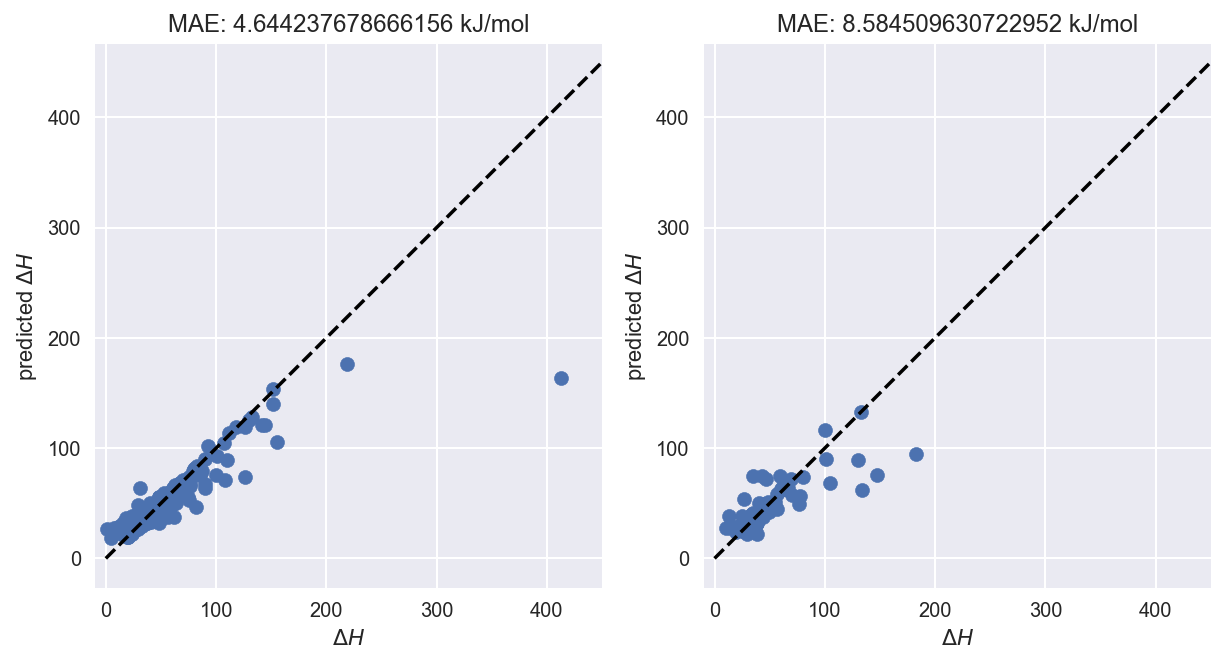

In [272]:
plt.figure(figsize=(10,5), tight_layout=False)
plt.subplot(1,2,1)
parity_plot(y_train, reg.best_estimator_.fit(X_train,y_train).predict(X_train), newfig=False)
plt.subplot(1,2,2)
parity_plot(y_val, reg.best_estimator_.fit(X_train,y_train).predict(X_val), newfig=False)

Even the "best estimator" severely mis-predicts the high ∆H cases, possible because it sub-samples the extreme values out - there's only 2, after all

## What is this model?

So it's a "Gradient Boosting Regressor", which means that it built up an ensemble of decision trees in an ad-hoc manner to iteratively decrease the testing residual. But what are these decision trees? And how are they deciding?

Text(0.5,0,'Iteration (# of Models)')

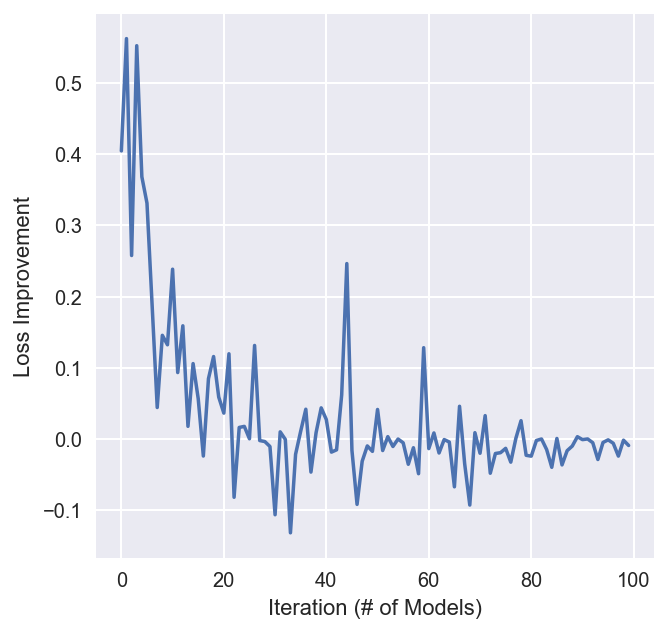

In [274]:
reg1 = reg.best_estimator_
plt.figure(figsize=(5,5), tight_layout=False)
plt.plot(reg1.oob_improvement_)
plt.ylabel('Loss Improvement')
plt.xlabel('Iteration (# of Models)')

This plot tells us how the model improved with each iteration, i.e. the addition of new models to its ensemble. Seems like adding models after 80 doesn't do much.

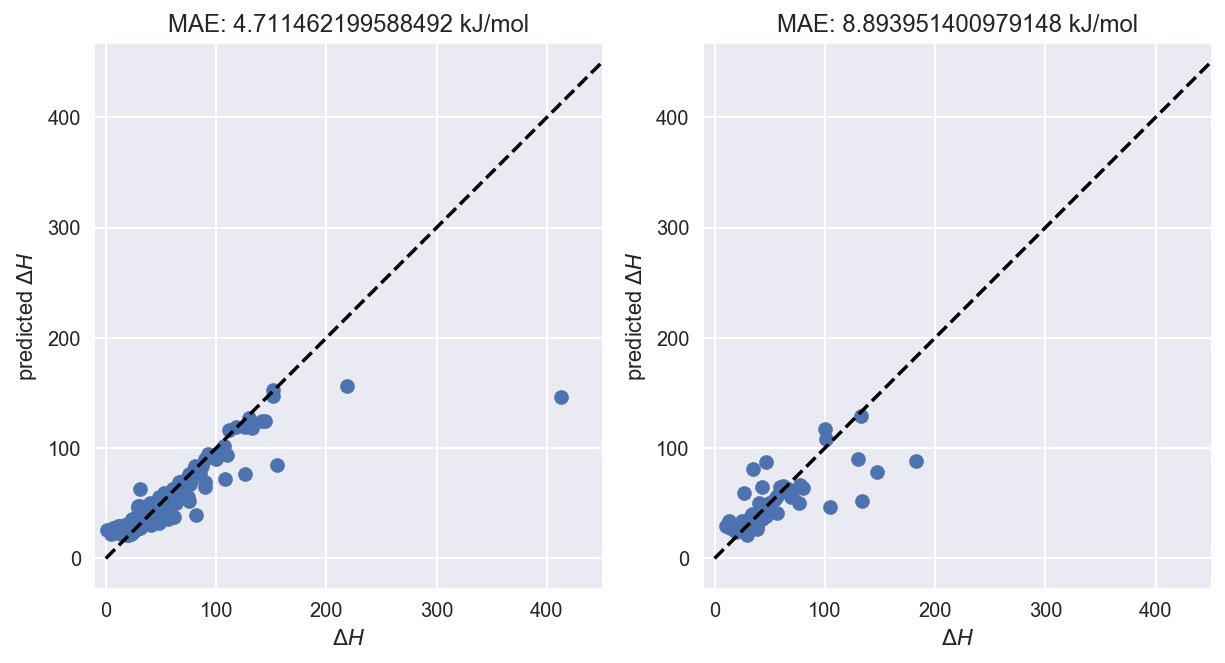

In [275]:
reg1.n_estimators=80
plt.figure(figsize=(10,5), tight_layout=False)
plt.subplot(1,2,1)
parity_plot(y_train, reg1.fit(X_train,y_train).predict(X_train), newfig=False)
plt.subplot(1,2,2)
parity_plot(y_val, reg1.fit(X_train,y_train).predict(X_val), newfig=False)

Yeah, that looks about the same, although training accuracy is quite a bit lower. Can we figure out which estimators were the most helpful? For example, take the ones that reduced the loss by the most, and just keep those?

In [288]:
tree0 = reg1.estimators_[0,0]
tree0

DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x10f914d38>,
           splitter='best')

In [ ]:
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

### 5. Digging deeper

Here are some primer questions to inspire you. These suggestions are roughly ordered according to how deep we think you'll need to dig in order to answer them.

Save your predictions for the independent test set from your favorite model -- we'll evaluate them at the end of the challenge!

#### Is linear regression better than (or as good as) random forest?
Can you train a regularized linear model that is better (or as good as) the RF model?

(Hint: make sure you re-compute the standardization on just the training set for each validation fold -- look into scikit-learn pipelines)

#### Do solid-solution compounds help?
There are no solid solutions in the hold-out set.... Does it help or hurt to include them in the training set?

#### Does it help to add structural information?
- Does it help to add structural information to your model? (e.g. the 'Material Class' column)
- What about training separate models for each different structure class?

#### Dealing with duplicate and near-duplicate compositions
There are a non-trivial number of  duplicate and near-duplicate compositions in the dataset -- with the randomized cross-validation procedure we've been using, it's possible that the same composition shows up in both training and validation sets.
- Does this significantly bias the estimated generalization performance? (To address this question, you might find helpful the example code on creating fair train/val splits at the end of the notebook.)

#### Model selection
Choose your favorite model from the MLMR workshop and do some hyperparameter tuning. Can you get better predictive performance?

#### Feature engineering
Magpie includes a diverse set of numerical and categorical properties of the elements. Some of the features in the magpie feature set may be more relevant than others to predicting the quality of hydrogen storage materials. (Consider e.g. the composition-averaged space group number....)
- can you train a model (need not be a random forest) with competetive performance using a hand-picked or automatically selected subset of magpie features?
- Consider using alternative features. (Check out some of the other feature sets available in [matminer](https://github.com/hackingmaterials/matminer), or come up with your own)

In [17]:
# further analysis here...


#### Example code for fair train/val splitting

In [17]:
# do a fair train/val split by splitting out unique compositions together, so that no unique composition shows up in both train and val
compositions = df.composition.apply(str).unique()
C_train, C_test = model_selection.train_test_split(compositions, test_size=0.25, random_state=42)

X_train = X[df.composition.apply(str).isin(C_train)]
y_train = y[df.composition.apply(str).isin(C_train)]

X_test = X[df.composition.apply(str).isin(C_test)]
y_test = y[df.composition.apply(str).isin(C_test)]

# standardize the input features for linear regression
# can skip this for e.g. random forest...
std = preprocessing.StandardScaler()
std.fit(X_train)
X_train, X_test = std.transform(X_train), std.transform(X_test)

In [18]:
# instead, do a fair train/val split by splitting out nearly-unique compositions separately
# this should split compounds up by considering only their constituent elements
compositions = df.composition.unique()
C_train, C_test = model_selection.train_test_split(compositions, test_size=0.25, random_state=42)

X_train = X[df.composition.isin(C_train)]
y_train = y[df.composition.isin(C_train)]

X_test = X[df.composition.isin(C_test)]
y_test = y[df.composition.isin(C_test)]

# standardize the input features for linear regression
# can skip this for e.g. random forest...
std = preprocessing.StandardScaler()
std.fit(X_train)
X_train, X_test = std.transform(X_train), std.transform(X_test)